In [ ]:
# X, y = datasets.fetch_california_housing(data_home="~/.cache/scikit_learn_data/", return_X_y=True)
# X, y = datasets.load_diabetes(return_X_y=True)
# X, y = datasets.make_friedman1(8000)
# X, y = datasets.make_friedman2([n_samples, noise)
# X, y = datasets.make_friedman3([n_samples, noise)
# X, y = datasets.make_regression([n_samples)
# X, y = datasets.make_sparse_uncorrelated()


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
import sklearn.metrics

from sklearn.utils.validation import Interval
from numbers import Integral, Real

ImportError: cannot import name 'Interval' from 'sklearn.utils.validation' (/nix/store/zs2svh0ggxnlqiz7zx8wgj9svaf4hwiy-python3.10-scikit-learn-1.1.3/lib/python3.10/site-packages/sklearn/utils/validation.py)

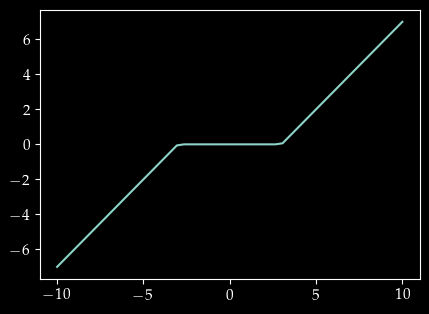

In [19]:
# S_a(x) = 0 si |x| < a,
# S_a(x) = x-a si x > a
# S_a(x) = a+x si x < -a

def softtruc(a, x):
  assert a >= 0
  return x * np.piecewise(x, [x < -a, np.abs(x) <= a, a < x], [1, 0, 1]) + np.piecewise(x, [x < -a, np.abs(x) <= a, a < x], [a, 0,-a])

plt.figure()
x = np.linspace(-10, 10)
plt.plot(x, softtruc(3, x))


In [28]:
from sklearn.base import RegressorMixin, MultiOutputMixin
from sklearn.linear_model import LinearRegression

class MyLasso(LinearRegression):

  # _parameter_constraints: dict = {
  #   "alpha": [Interval(Real, 0, None, closed="left")],
  #   "max_iter": [Interval(Integral, 1, None, closed="left"), None],
  # }

  def __init__(self, alpha=0.5, *, gamma=1, max_iter=1000, random_state=None):
    self.alpha = alpha
    self.gamma = gamma
    self.max_iter = max_iter
    self.random_state = random_state

  def fit(self, X, y=None):
    # self._validate_params()

    X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)

    n_samples, n_features = X.shape
    n_targets = len(y)

    phi = np.zeros(n_features)
    z = np.zeros(n_features)
    x = np.zeros(n_features)


    bla = np.linalg.inv(X.T @ X + self.gamma * np.eye(n_features))

    for t in range(1, self.max_iter):
      x = bla @ (X.T @ (y - X @ (z - self.gamma*phi)))
      # optinal noise here on x
      z = softtruc(self.gamma*self.alpha, x + self.gamma*phi)
      phi = phi + 1/self.gamma * (x - z)

    self.coef_ = x[:-1]
    self.intercept_ = x[-1]

    return self
  
  def predict(self, X):
    return np.clip(X @ self.coef_+ self.intercept_, 0, np.infty)



In [29]:
X, y = datasets.load_diabetes(return_X_y=True)
X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)


lasso = MyLasso(random_state=0)
alphas = np.geomspace(1, 10000, 30, dtype=int)

tuned_parameters = [{"max_iter": alphas}]
n_folds = 10

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X, y)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]


In [32]:
import pandas as pd

pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010431,0.006740,0.001476,0.002391,1,{'max_iter': 1},-3.664924,-4.128550,-4.645640,-3.858104,-4.308335,-3.240104,-3.560049,-6.695366,-3.449512,-4.099837,-4.165042,0.934744,28
1,0.011668,0.006673,0.006977,0.010404,1,{'max_iter': 1},-3.664924,-4.128550,-4.645640,-3.858104,-4.308335,-3.240104,-3.560049,-6.695366,-3.449512,-4.099837,-4.165042,0.934744,28
2,0.004570,0.002963,0.000763,0.000282,1,{'max_iter': 1},-3.664924,-4.128550,-4.645640,-3.858104,-4.308335,-3.240104,-3.560049,-6.695366,-3.449512,-4.099837,-4.165042,0.934744,28
3,0.005508,0.005586,0.000513,0.000205,2,{'max_iter': 2},0.421521,0.169642,0.357520,0.512200,0.285804,0.514068,0.388015,0.484515,0.396162,0.525307,0.405475,0.108017,1
4,0.006489,0.003597,0.000472,0.000111,3,{'max_iter': 3},-3.309636,-3.921723,-4.189753,-3.338342,-3.924979,-2.827373,-3.300710,-5.865966,-3.068900,-3.631795,-3.737918,0.813861,27
5,0.005958,0.006164,0.000541,0.000321,4,{'max_iter': 4},0.370126,0.138460,0.322614,0.434580,0.264538,0.443278,0.342112,0.448180,0.347198,0.454494,0.356558,0.094478,2
6,0.001450,0.001235,0.000500,0.000338,6,{'max_iter': 6},0.346168,0.123632,0.305268,0.393570,0.248837,0.408093,0.312780,0.418727,0.319686,0.422548,0.329931,0.087766,3
7,0.001489,0.001271,0.000349,0.000060,9,{'max_iter': 9},-3.132241,-3.865688,-3.874002,-3.011807,-3.634950,-2.564643,-3.123466,-5.284323,-2.843122,-3.344462,-3.467871,0.728782,26
8,0.001400,0.000836,0.000326,0.000051,12,{'max_iter': 12},0.319153,0.109804,0.283106,0.345891,0.229346,0.368864,0.274480,0.377126,0.286564,0.388171,0.298250,0.079493,4
9,0.002291,0.001469,0.000433,0.000297,17,{'max_iter': 17},-3.084135,-3.833921,-3.787323,-2.931121,-3.542378,-2.498203,-3.063986,-5.135624,-2.781318,-3.261442,-3.391945,0.708382,25


(1, 10000)

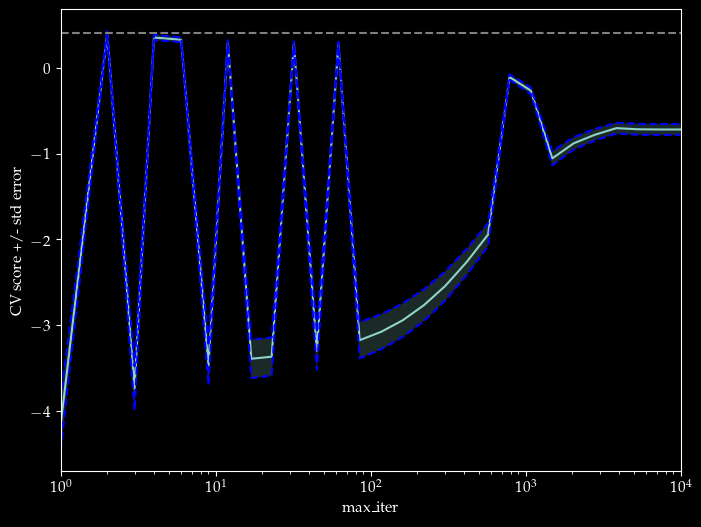

In [30]:

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, "b--")
plt.semilogx(alphas, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("max_iter")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([alphas[0], alphas[-1]])